<a href="https://colab.research.google.com/github/ponakilan/vid-anomaly/blob/main/MSTA_%2B_3D_Conv_IPAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect Google Drive
Mount google drive to:
- Load dataset
- Store and load model checkpoints

In [1]:
from google.colab import drive, runtime
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ! 7z x '/content/drive/MyDrive/Research Credit/IPAD_dataset.zip'

! unzip -q '/content/drive/MyDrive/Research Credit/IPAD_dataset.zip' 'IPAD_dataset/R01/*'

In [15]:
import os
import torch

torch.manual_seed(0)

SEQ_LEN = 8
EPOCHS = 20
BATCH_SIZE = 7
SCALES = [2, 4, 8, 10]

DATA_ROOT = "/content/IPAD_dataset/R01"
RC_ROOT = "/content/drive/MyDrive/Research Credit"

TRAIN_DIR = f"{DATA_ROOT}/training/frames"
TEST_DIR = f"{DATA_ROOT}/testing/frames"
LABELS_PATH = f"{DATA_ROOT}/test_label"

NUM = len(os.listdir(f"{RC_ROOT}/Models"))
CKPT_PATH = f"{RC_ROOT}/Models/ckpt_{SEQ_LEN}_{NUM}.pth"
TEST_SAVE_PATH = f"{RC_ROOT}/Results/res_{NUM}.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define PyTorch Dataset
- Load a sequence of frames from the given root directory.
- Apply transforms.
- Convert frames into 768-D embeddings using ViT.

Returns the embedding and the original image for loss calculation.

In [3]:
import math

from PIL import Image
from torchvision.datasets import DatasetFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel

transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

def load_image(path):
    image = Image.open(path).convert("RGB")
    return image

img_label_dataset = DatasetFolder(
    root=TRAIN_DIR,
    loader=load_image,
    is_valid_file=lambda x: True
)

class ImgDataset(Dataset):
    def __init__(self, dataset, seq_len=SEQ_LEN):
        self.dataset = dataset
        self.seq_len = seq_len

    def __len__(self):
        return math.ceil(len(self.dataset) / self.seq_len)

    def __getitem__(self, idx):
        start_idx = idx * self.seq_len
        end_idx = min(start_idx + self.seq_len, len(self.dataset))
        sequence = [self.dataset[i] for i in range(start_idx, end_idx)]
        labels = [data[1] for data in sequence]
        is_valid = all(label == labels[0] for label in labels)
        if is_valid:
            images = torch.stack([transform(data[0]) for data in sequence])
            if len(images) < self.seq_len:
                images = torch.cat([images, torch.zeros(self.seq_len - len(images), 3, 224, 224)])
        else:
            images = torch.zeros(self.seq_len, 3, 224, 224)

        return images.permute(1, 0, 2, 3), images.permute(1, 0, 2, 3)

## MSTA

In [4]:
import torch
import torch.nn.functional as F
from torch import nn

class MultiScaleTemporalAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, device, scales=[2, 4, 8, 10]):
        super().__init__()
        self.scales = scales
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim, num_heads).to(device) for _ in scales
        ])

    def forward(self, x):
        B, T, D = x.shape
        outputs = []

        for i, window_size in enumerate(self.scales):
            attn_device = next(self.attention_layers[i].parameters()).device
            if window_size >= T:
                q = k = v = x.transpose(0, 1).to(attn_device)
                attn_output, _ = self.attention_layers[i](q, k, v)
                outputs.append(attn_output.transpose(0, 1))
            else:
                local_outputs = []
                for start in range(T - window_size + 1):
                    chunk = x[:, start:start + window_size, :].to(attn_device)
                    q = k = v = chunk.transpose(0, 1)
                    attn_output, _ = self.attention_layers[i](q, k, v)
                    local_outputs.append(attn_output.mean(0))
                local_output = torch.stack(local_outputs, dim=1)
                local_output = F.interpolate(local_output.transpose(1, 2), size=T, mode='linear').transpose(1, 2)
                outputs.append(local_output)

        final_output = torch.stack(outputs, dim=0).mean(0)
        return final_output  # (B, T, D)

## Vision Transformer

In [5]:
from transformers import ViTImageProcessor, ViTModel

class ViT(nn.Module):
    def __init__(self):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(self.device)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        vectors = []
        for images in x:
            inputs = self.processor(
                images=images,
                return_tensors="pt"
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            outputs = self.model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            encoding = last_hidden_states[:, 0, :]
            vectors.append(encoding)
        vectors = torch.stack(vectors, dim=0)
        return vectors

## 3D Conv

In [6]:
import torch.nn as nn
from functools import reduce
from operator import mul
import torch

class Reconstruction3DEncoder(nn.Module):
    def __init__(self, chnum_in):
        super(Reconstruction3DEncoder, self).__init__()

        # Dong Gong's paper code
        self.chnum_in = chnum_in
        feature_num = 128
        feature_num_2 = 96
        feature_num_x2 = 256
        self.encoder = nn.Sequential(
            nn.Conv3d(self.chnum_in, feature_num_2, (3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1)),
            nn.BatchNorm3d(feature_num_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(feature_num_2, feature_num, (3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.BatchNorm3d(feature_num),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(feature_num, feature_num_x2, (3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.BatchNorm3d(feature_num_x2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(feature_num_x2, feature_num_x2, (3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.BatchNorm3d(feature_num_x2),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Reconstruction3DDecoder(nn.Module):
    def __init__(self, chnum_in):
        super(Reconstruction3DDecoder, self).__init__()

        # Dong Gong's paper code + Tanh
        self.chnum_in = chnum_in
        feature_num = 128
        feature_num_2 = 96
        feature_num_x2 = 256
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(feature_num_x2, feature_num_x2, (3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1),
                               output_padding=(1, 1, 1)),
            nn.BatchNorm3d(feature_num_x2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose3d(feature_num_x2, feature_num, (3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1),
                               output_padding=(1, 1, 1)),
            nn.BatchNorm3d(feature_num),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose3d(feature_num, feature_num_2, (3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1),
                               output_padding=(1, 1, 1)),
            nn.BatchNorm3d(feature_num_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose3d(feature_num_2, self.chnum_in, (3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1),
                               output_padding=(0, 1, 1)),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

## Frame reconstruction Model

In [12]:
class FrameReconstructionModel(torch.nn.Module):
    def __init__(self, seq_len=SEQ_LEN):
        super(FrameReconstructionModel, self).__init__()

        self.seq_len = seq_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.vit = ViT()
        self.attn = MultiScaleTemporalAttention(embed_dim=768, num_heads=8, device=self.device, scales=SCALES)

        self.encoder = Reconstruction3DEncoder(chnum_in=3).to(self.device)
        self.decoder = Reconstruction3DDecoder(chnum_in=3).to(self.device)

        self.seq_dim = 768
        self.seq_len = seq_len
        self.spatial_channels = 256
        self.merge_type = "add"

        self.projection = nn.Linear(seq_len * self.seq_dim, self.spatial_channels)

        self.activation = nn.ReLU()

        if self.merge_type == 'both':
            self.projection_add = nn.Linear(self.seq_len * self.seq_dim, self.spatial_channels)

    def _merge(self, seq_embedding, spatial_embedding):
        batch_size = seq_embedding.size(0)

        seq_flat = seq_embedding.reshape(batch_size, -1)

        channel_modulators = self.projection(seq_flat)

        channel_modulators = self.activation(channel_modulators)

        modulators = channel_modulators.view(batch_size, self.spatial_channels, 1, 1, 1)

        if self.merge_type == 'mul':
            return spatial_embedding * modulators

        elif self.merge_type == 'add':
            return spatial_embedding + modulators

        elif self.merge_type == 'both':
            add_modulators = self.projection_add(seq_flat)
            add_modulators = self.activation(add_modulators)
            add_modulators = add_modulators.view(batch_size, self.spatial_channels, 1, 1, 1)

            result = spatial_embedding * modulators + add_modulators
            return result

    def forward(self, images):
        x = self.vit(images)
        sequential_embedding = self.attn(x)
        spatial_embedding = self.encoder(images)
        merged_embedding = self._merge(sequential_embedding, spatial_embedding)
        output = self.decoder(merged_embedding)

        return output

In [13]:
# Test
dataset = ImgDataset(img_label_dataset)
model = FrameReconstructionModel().to(device)
data = dataset[0][0].unsqueeze(0).to(device)
model(data).shape

torch.Size([1, 3, 8, 224, 224])

# Training

Number of samples: 976


SuggestedLRs(valley=0.0003981071640737355)

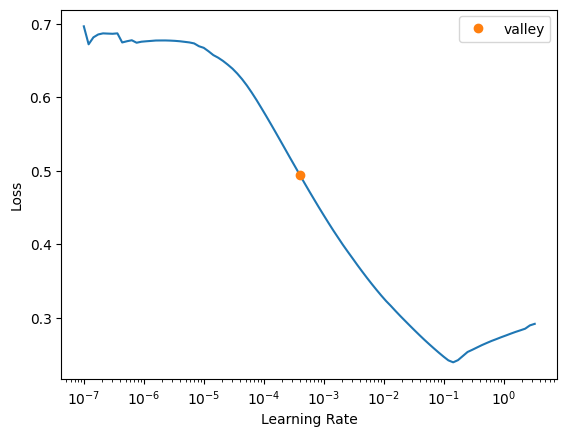

In [14]:
from fastai.vision.learner import Learner
from torch.utils.data import random_split
from fastai.vision.all import *

dataset = ImgDataset(img_label_dataset)
print(f"Number of samples: {len(dataset)}")

model = FrameReconstructionModel().to(device)
# model = FrameReconstructionModel(device=device).to(device)
loss_func = MSELossFlat()

train_size = int(0.85 * len(dataset))
valid_size = len(dataset) - train_size
train_ds, valid_ds = random_split(dataset, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
dls = DataLoaders(train_dl, valid_dl)

learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=Adam)

learn.lr_find()

In [16]:
learn.fine_tune(EPOCHS, cbs=[
    SaveModelCallback(monitor='valid_loss', fname=CKPT_PATH, every_epoch=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2)
])

epoch,train_loss,valid_loss,time
0,0.043310,0.014459,05:08


epoch,train_loss,valid_loss,time
0,0.010214,0.009211,05:09
1,0.006354,0.004935,05:09
2,0.004802,0.004338,05:08
3,0.002886,0.002423,05:07
4,0.002438,0.002187,05:08
5,0.002041,0.001707,05:08
6,0.002013,0.003996,05:07
7,0.001792,0.001172,05:07
8,0.001449,0.001172,05:07
9,0.001202,0.001023,05:08


No improvement since epoch 10: early stopping


In [17]:
torch.save(learn.model.state_dict(), CKPT_PATH)
print(f"Model saved to {CKPT_PATH}")

Model saved to /content/drive/MyDrive/Research Credit/Models/ckpt_8_3.pth


# Testing

In [20]:
import os

import torch
import numpy as np

def load_model_from_ckpt(state_dict_path: str):
    model = FrameReconstructionModel()
    model.load_state_dict(torch.load(state_dict_path, map_location="cpu", weights_only=False))

    return model

def load_test_frames(test_dir: str, seq_len: int):
    test_dataset = DatasetFolder(
        root=test_dir,
        loader=load_image,
        transform=Compose([
            Resize((224, 224)),
            ToTensor()
        ]),
        is_valid_file=lambda x: True
    )

    test_dataset = ImgDataset(test_dataset, seq_len=seq_len)

    return test_dataset

def load_labels(labels_path: str, seq_len: int):
    label_files = os.listdir(labels_path)
    labels = []
    for label_file in label_files:
        label = np.load(f"{labels_path}/{label_file}")
        labels.append(label)

    labels = np.hstack(labels)
    labels = labels.tolist()

    labels_seq = []
    for i in range(0, len(labels), seq_len):
        temp = labels[i:i+seq_len]
        if all(label == temp[0] for label in temp):
            labels_seq.append(1)
        else:
            labels_seq.append(0)

    return labels_seq

In [21]:
from tqdm import tqdm
import pandas as pd
from fastai.vision.all import *

test_dataset = load_test_frames(TEST_DIR, SEQ_LEN)
test_labels = load_labels(LABELS_PATH, SEQ_LEN)

# model = load_model_from_ckpt("/content/drive/MyDrive/Research Credit/Models/ckpt_10_0.pth")
model = load_model_from_ckpt(CKPT_PATH)
model.to(device)
model.eval()

loss_func = MSELossFlat()

errors = []
for i in tqdm(range(len(test_dataset))):
    embed, image = test_dataset[i]
    embed, image = embed.to(device).unsqueeze(0), image.to(device).unsqueeze(0)

    with torch.no_grad():
        reconstructed = model(embed)
        error = loss_func(reconstructed, image)
    errors.append(error.cpu().item())

    del embed, image, reconstructed, error
    torch.cuda.empty_cache()

100%|██████████| 461/461 [01:12<00:00,  6.39it/s]


In [22]:
if len(errors) == len(test_labels):
    result_df = pd.DataFrame({
        "error": errors,
        "label": test_labels
    })
    result_df.to_csv(TEST_SAVE_PATH, index=False)
    print(f"Test results saved to {TEST_SAVE_PATH}.")

else:
    print("Results saving failed.")

Test results saved to /content/drive/MyDrive/Research Credit/Results/res_3.csv.


### Analysis

In [23]:
import pandas as pd

# TEST_SAVE_PATH = "/content/drive/MyDrive/Research Credit/Results/res_1.csv"

test_df = pd.read_csv(TEST_SAVE_PATH)
test_df.head()

,error,label
0,0.002809,1
1,0.002909,1
2,0.002962,1
3,0.002965,0
4,0.003033,1


In [24]:
import numpy as np
from sklearn.metrics import roc_curve, auc

errors = test_df['error'].values
labels = test_df['label'].values

fpr, tpr, thresholds = roc_curve(labels, errors)

j_scores = tpr - fpr
optimal_threshold = thresholds[np.argmax(j_scores)]
print(f"Optimal threshold: {optimal_threshold}")

binary_predictions = (errors >= optimal_threshold).astype(int)

fpr_best, tpr_best, _ = roc_curve(labels, binary_predictions)
auc_at_best_threshold = auc(fpr_best, tpr_best)

print(f"AUC at best threshold: {auc_at_best_threshold}")

Optimal threshold: 0.0028604923281818
AUC at best threshold: 0.5687120485778203


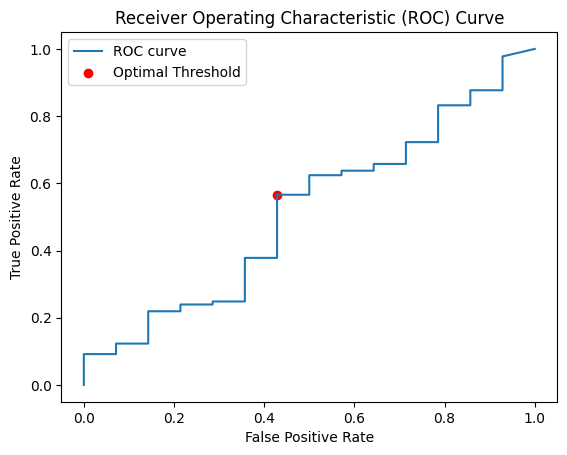

In [25]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve')
plt.scatter(fpr[np.argmax(j_scores)], tpr[np.argmax(j_scores)], marker='o', color='red', label='Optimal Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
drive.flush_and_unmount()
runtime.unassign()